This file contains python code to check the hypothesis testing

I can get good match to the theoretical when sample size is large enough (n=5000)

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint


In [3]:
import importlib
import constants
importlib.reload(constants)

<module 'constants' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/test_bak_notebooks/../../mypkg/constants.py'>

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from hdf_utils.hypo_test import obt_test_stat_simple2
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization


from penalties.scad_pen import SCAD
from models.logistic_model import LogisticModel
from models.linear_model import LinearModel

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Param and fns

### Params

In [45]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 20
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]
paras.ind_freq = np.linspace(1, 40, 40) # freqs
paras.init_noise_sd = 0 # the sd of the noise added to the true value for initial values
paras.SIS_ratio = 1 # the ratio to keep with SIS procedure
#paras.SIS_ratio = 0.02 # the ratio to keep with SIS procedure
paras.svdinv_eps_Q = 1
paras.svdinv_eps_Psi = 1

# generating dataset
paras.n = 5000 # num of data obs to be genareted
paras.npts = 40 # num of pts to evaluate X(s)
paras.d = 20 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 0.1 # variance of the error
paras.types_ = ["int", 2, 2, "c", "c"]

# b-spline
paras.N = 6 # int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mat = torch.DoubleTensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord))
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
paras.alp_GT = np.array([5, 1, -2, 3, -4])

# first way
#beta_type_GT = [fn1, fn2, fn2] + [zero_fn]*(paras.d-3-2) + [fn1, fn2]
#paras.beta_GT = np.array([_fn(paras.x) for _fn in beta_type_GT]).T
# second way, fourier basis
paras.fourier_basis = fourier_basis_fn(paras.x)
paras.fourier_basis_coefs = ([0*coef_fn(0.3), 0*coef_fn(0.3)] + 
                             [np.zeros(50)] * (paras.d-2-2) +
                             [coef_fn(0.7)*0, coef_fn(0.9)]
                             )
#paras.fourier_basis_coefs = ([np.zeros(50)] * (paras.d-2) +
#                             [coef_fn(0.7), coef_fn(0.9)]
#                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T * 5
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs #* 10
#
paras.Gam_GT_est = (np.linalg.inv(paras.basis_mat.numpy().T 
                               @ paras.basis_mat.numpy()) 
                               @ paras.basis_mat.numpy().T 
                               @ paras.beta_GT)

# optimization
paras.Rmin = 2*(np.linalg.norm(paras.Gam_GT_est/np.sqrt(paras.N), axis=0).sum() + np.abs(paras.alp_GT).sum())
paras.Rmin = 10000
paras.sel_idx = np.arange(4, paras.d) # M^c set, 
#without loss of generality, we assume the idxs in M is the first m betas
paras.num_cv_fold = 5
paras.Rfct = 2
#paras.stop_cv = 5e-5
paras.stop_cv = 5e-4
#paras.max_iter = 10000
paras.max_iter = 2000

# hypothesis test
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
#paras.Cmat = np.eye(len(paras.M_idxs)) # Cmat \times beta_M(s), r x m
#paras.Cmat = np.array([1, -1]).reshape(-1, 2) # Cmat \times beta_M(s), r x m
paras.Cmats = [
    np.eye(len(paras.M_idxs)), # m x m I matrix, [beta1, beta2] = [0, 0]
    np.array([1, 1, -1, -1]).reshape(1, 4), # beta1-beta2
    np.array([1, 1, 1, 1]).reshape(1, 4), # beta1+beta2
]
#paras.r, paras.m = paras.Cmat.shape
#paras.t_vec = np.zeros(paras.Cmat.shape[0]) # t vec, typically it is zero vector


The number of B-spline basis is 6.


In [32]:
paras.save_dir = RES_ROOT/"linear_test"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

### Fns

In [25]:

def MS2idxs(q, N, MS_unions):
    """This fn is to return the idxs to keep in mat Q, Sigma and vec Theta
    """
    idxs_all = [np.arange(0, q)]
    for cur_idx in MS_unions:
        idxs_all.append(np.arange(q+cur_idx*N, q+(cur_idx+1)*N))
    idxs_all = np.concatenate(idxs_all)
    return idxs_all

In [26]:

def get_Amat(k, Cmat, paras):
    """Get A matrix for hypothesis test
        k: Num of elements in S
        Cmat: Hypothesis matrix
        paras: parameters
                required: N, m, q
    """
    _paras = edict(paras.copy())
    
    m = Cmat.shape[-1]
    part1 = np.kron(Cmat, np.eye(_paras.N))
    part2 = np.zeros((m*_paras.N, _paras.q+(m+k)*_paras.N))
    part2[:, _paras.q:(_paras.q+m*_paras.N)] = np.eye(m*_paras.N)
    A = part1 @ part2
    return A

In [27]:
def get_filename(params):
    keys = ["seed", "n", "d", "decimate_rate"]
    return '_'.join(f"{k}-{params[k]}" for k in keys) + '.pkl'
def _gen_simu_data_all(seed, paras):
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    tmp_paras = edict()
    tmp_paras.seed = seed 
    tmp_paras.n = 1000
    #tmp_paras.n = _paras.n
    tmp_paras.d = _paras.d
    tmp_paras.decimate_rate = 30
    
    #file_path = MIDRES_ROOT/get_filename(tmp_paras)
    #if file_path.exists():
    #    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts) /10
    #    simu_curvs = load_pkl(file_path, verbose=False)
    #else:
    #    simu_curvs = gen_simu_ts(_paras.n, _paras.d, 5, decimate_rate=tmp_paras.decimate_rate, verbose=False)
    #    save_pkl(file_path, simu_curvs)
    #simu_curvs = gen_simu_psd(_paras.n, _paras.d, 10)
    #simu_curvs = 1*(simu_curvs- simu_curvs.mean(axis=2, keepdims=True))/simu_curvs.std(axis=2, keepdims=True)
    simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts) * 2
    #simu_curvs = (simu_curvs)/simu_curvs.std(axis=2)[:, :, np.newaxis]
    #simu_curvs = simu_curvs + np.random.randn(_paras.n, _paras.d, 1)*0.5
    simu_curvs = simu_curvs[:_paras.n, :, :_paras.npts]
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    
    
    # Y 
    rvs = np.random.rand(_paras.n)
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # To torch
    X = torch.Tensor(simu_curvs) # n x d x npts
    Z = torch.Tensor(simu_covs) # n x q
    Y = torch.Tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    return all_data

In [28]:
def obt_test_stat(model, est_alp, est_Gam, Cmat, paras):
    """Obtiaining the test statistics via the estimator
        args:
            model: The model you used, LinearModel or LogisticModel
            est_alp: Estimated alp parameters
            est_Gam: Estimated Gam parameters
    """
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, Cmat, _paras))
    
    # calcuate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    Q_mat_part_inv = torch.pinverse(Q_mat_part)
    #Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps_Q)
    
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    Psi_inv = torch.pinverse(Psi)
    #Psi_inv = svd_inverse(Psi, _paras.svdinv_eps_Psi)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    return T_v

## Simu

### Backup

In [ ]:
# for back up
seed = 1
#lam = 3
lam = 2.0
#lam = 0.5
#lam = 0.6
#lam = 30
T_vs = []
T_p1s = []
Q_mat_parts = []
Psis = []
nonzero_idxss = []
est_alps = []
for seed in trange(0, 1000):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    est_Gam_full = torch.zeros_like(torch.tensor(paras.Gam_GT_est));
        
    _paras = edict(paras.copy())
    _paras.lam = lam
    _paras.seed = seed
    _paras.Rv = _paras.Rfct * _paras.Rmin
    cur_data = _gen_simu_data_all(_paras.seed, _paras)
    
    
    # do sure independent screening for dim reduction
    if _paras.SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.SIS_ratio, _paras, ridge_pen=1)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    #print(keep_idxs)
        
    _paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
    _paras.d_SIS = len(_paras.keep_idxs)
    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
    
    alp_init = torch.Tensor(_paras.alp_GT) + torch.randn(_paras.q)*_paras.init_noise_sd
    Gam_init = (torch.Tensor(_paras.Gam_GT_est[:, _paras.keep_idxs]) 
                + torch.randn(_paras.N, _paras.d_SIS)*_paras.init_noise_sd)
    theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
    rhok_init = torch.randn(_paras.d_SIS*_paras.N)
        
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    # 3e0
    pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)
        
    
    main_res = optimization(model=model, 
                            penalty=pen, 
                            inits=[alp_init, Gam_init, theta_init, rhok_init],
                            is_prg=False,
                            save_paras=False,    
                            input_paras=_paras)
    
    #cv_errs = CV_err_linear_fn(data=cur_data_SIS, 
    #                           penalty=pen, 
    #                           num_cv_fold=_paras.num_cv_fold,
    #                           inits=[alp_init, Gam_init, theta_init, rhok_init], 
    #                           is_prg=False, 
    #                           save_paras=False,    
    #                           input_paras=_paras)
    #print(np.mean(cv_errs**2))
    
    opt = main_res[0]
    est_Gam = opt.Gamk
    est_alp = opt.alpk
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    est_Gam_full[:, _paras.keep_idxs] = est_Gam.clone()
    est_alps.append(est_alp.numpy())
    
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    #print(nonzero_idxs)
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    tT_vs = []
    for Cmat in _paras.Cmats:
        Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
        Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
        _paras.svdinv_eps_Psi = 1e-7
        _paras.svdinv_eps_Q = 1e-7
        T_v = obt_test_stat_simple2(Q_mat_part, Sig_mat_part, est_alp, est_Gam, Cmat, _paras)
        tT_vs.append(T_v.item())
        
        #Amat = torch.Tensor(get_Amat(k, Cmat, _paras))
        #
        ## calcuate Test stats
        #Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
        #Q_mat_part_inv = torch.pinverse(Q_mat_part)
        ##Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps_Q)
        #
        #Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
        #Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
        #
        #T_p1 = Amat @ est_theta[keep_idxs_test]
        #Psi_inv = torch.pinverse(Psi)
        ##Psi_inv = svd_inverse(Psi, _paras.svdinv_eps_Psi)
        #T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
        #tT_vs.append(T_v.item())
    
    #Psis.append(Psi)
    #Q_mat_parts.append(Q_mat_part)
    #T_p1s.append(T_p1)
    T_vs.append(tT_vs)
    nonzero_idxss.append(nonzero_idxs)
    
    #print(torch.stack([
    #torch.norm(est_Gam, dim=0),
    #torch.norm(Gam_init, dim=0),
    #torch.tensor(np.linalg.norm(paras.Gam_GT_est, axis=0)[_paras.keep_idxs])]))

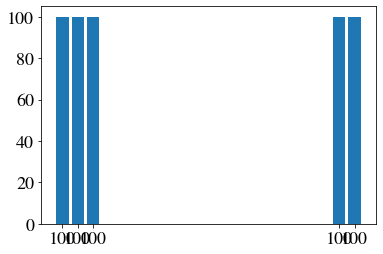

In [33]:
idxs, cts = np.unique(np.concatenate(nonzero_idxss), return_counts=True)
plt.bar(idxs, cts)
plt.xticks(idxs, cts);

In [ ]:
tmp1 = np.mean([ix.numpy() for ix in Psis], axis=0)/paras.n
sns.heatmap(tmp1, center=0, cmap="bwr")

<Axes: >

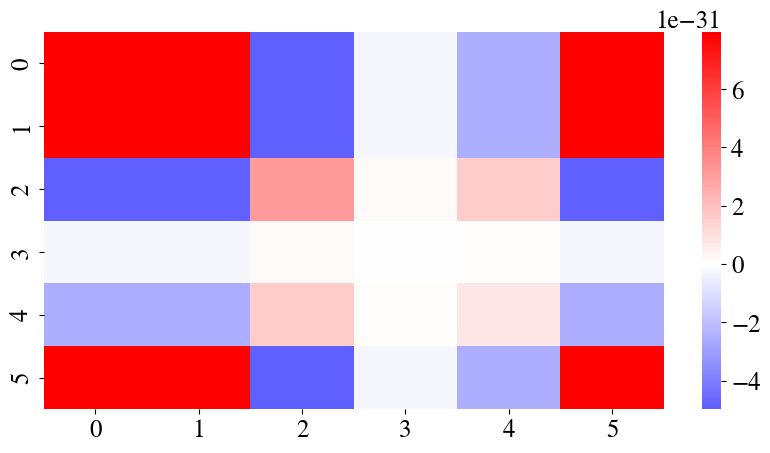

In [83]:
tmp2 = np.cov(np.array([ix.numpy() for ix in T_p1s]).T)
sns.heatmap(tmp2, center=0, cmap="bwr")

### Run

In [48]:
seed = 1
#lam = 3
lam = 2.0
#lam = 0.5
#lam = 0.6
#lam = 30
T_vs = []
def _run_fn(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.set_default_tensor_type(torch.DoubleTensor)
    est_Gam_full = torch.zeros_like(torch.tensor(paras.Gam_GT_est));
        
    _paras = edict(paras.copy())
    _paras.lam = lam
    _paras.seed = seed
    _paras.Rv = _paras.Rfct * _paras.Rmin
    cur_data = _gen_simu_data_all(_paras.seed, _paras)
    
    
    # do sure independent screening for dim reduction
    if _paras.SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.SIS_ratio, _paras, ridge_pen=1)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    #print(keep_idxs)
        
    _paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
    _paras.d_SIS = len(_paras.keep_idxs)
    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
    
    alp_init = torch.Tensor(_paras.alp_GT) + torch.randn(_paras.q)*_paras.init_noise_sd
    Gam_init = (torch.Tensor(_paras.Gam_GT_est[:, _paras.keep_idxs]) 
                + torch.randn(_paras.N, _paras.d_SIS)*_paras.init_noise_sd)
    theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
    rhok_init = torch.randn(_paras.d_SIS*_paras.N)
        
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    # 3e0
    pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)
        
    
    main_res = optimization(model=model, 
                            penalty=pen, 
                            inits=[alp_init, Gam_init, theta_init, rhok_init],
                            is_prg=False,
                            save_paras=False,    
                            input_paras=_paras)
    
    #cv_errs = CV_err_linear_fn(data=cur_data_SIS, 
    #                           penalty=pen, 
    #                           num_cv_fold=_paras.num_cv_fold,
    #                           inits=[alp_init, Gam_init, theta_init, rhok_init], 
    #                           is_prg=False, 
    #                           save_paras=False,    
    #                           input_paras=_paras)
    #print(np.mean(cv_errs**2))
    
    opt = main_res[0]
    est_Gam = opt.Gamk
    est_alp = opt.alpk
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    est_Gam_full[:, _paras.keep_idxs] = est_Gam.clone()
    
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    #print(nonzero_idxs)
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    tT_vs = []
    for Cmat in _paras.Cmats:
        Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
        Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
        _paras.svdinv_eps_Psi = 1e-8
        _paras.svdinv_eps_Q = 1e-8
        T_v = obt_test_stat_simple2(Q_mat_part, Sig_mat_part, est_alp, est_Gam, Cmat, _paras)
        tT_vs.append(T_v.item())
        
        #Amat = torch.Tensor(get_Amat(k, Cmat, _paras))
        #
        ## calcuate Test stats
        #Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
        #Q_mat_part_inv = torch.pinverse(Q_mat_part)
        ##Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps_Q)
        #
        #Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
        #Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
        #
        #T_p1 = Amat @ est_theta[keep_idxs_test]
        #Psi_inv = torch.pinverse(Psi)
        ##Psi_inv = svd_inverse(Psi, _paras.svdinv_eps_Psi)
        #T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
        #tT_vs.append(T_v.item())
    
    return tT_vs

with Parallel(n_jobs=20) as parallel:
    T_vs = parallel(delayed(_run_fn)(cur_seed)  
                             for cur_seed in tqdm(range(500), total=500))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.40it/s]


size is 0.062. (4, 4)
size is 0.056. (1, 4)
size is 0.050. (1, 4)


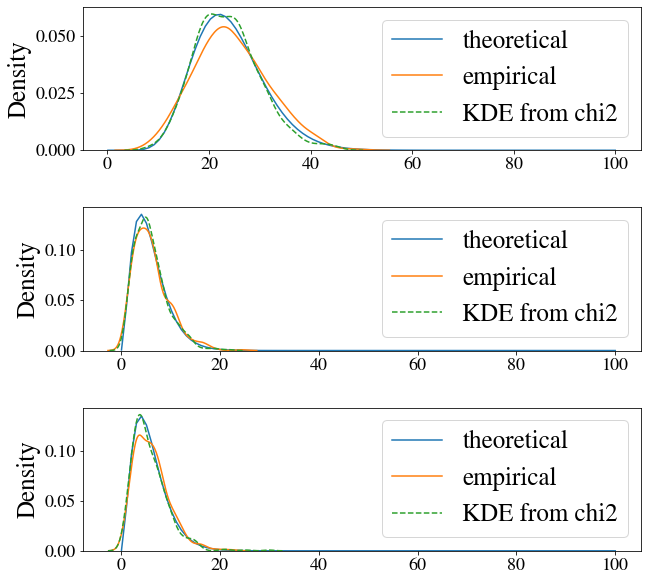

In [49]:
def _filtered_outliers(vec):
    vec = np.array(vec)
    Q1, Q3 = np.quantile(vec, [0.25, 0.75])
    IQR = Q3-Q1
    lb, ub = Q1-1.5*IQR, Q3+1.5*IQR
    #vec_filtered = vec[(vec>0) & (vec<30)]
    vec_filtered = vec[(vec>lb) & (vec<ub)]
    vec_filtered = vec
    return vec_filtered

from scipy.stats import chi2
plt.figure(figsize=[10, 10])
T_vs = np.array(T_vs)
xs = np.linspace(0.1, 100, 100)
for idx, Cmat in enumerate(paras.Cmats):
    plt.subplot(3, 1, idx+1)
    chi_df = Cmat.shape[0]*paras.N
    sps_from_true = chi2.rvs(df=chi_df, size=len(T_vs[:, idx]))
    curTvs = _filtered_outliers(T_vs[:, idx])
    pvals = chi2.sf(curTvs, chi_df)
    pvals1 = chi2.sf(sps_from_true, chi_df)
    print(f"size is {np.mean(pvals<0.05):.3f}.", Cmat.shape)
    theo_curvs_log = chi2.logpdf(xs, chi_df);
    plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
    sns.kdeplot(curTvs, label="empirical")
    sns.kdeplot(sps_from_true, ls="--", label="KDE from chi2")
    plt.legend()

In [56]:
T_vs.shape
sps_from_true = chi2.rvs(df=chi_df, size=len(T_vs[:, 0]))
sps_from_true.mean()

6.160857939199605

In [44]:

sizes = []
for ix in range(1000):
    chi_df = 1 * paras.N
    sps_from_true = chi2.rvs(df=chi_df, size=len(T_vs[:, 0]))
    pvals1 = chi2.sf(sps_from_true, chi_df)
    size = np.mean(pvals1<0.05)
    sizes.append(size)
sizes = np.array(sizes);
np.mean(sizes <0.08)

0.869

0.614

In [23]:
CV = chi2.ppf(0.95, chi_df)
np.mean(T_vs_new>CV), np.mean(sps_from_true>CV)

(0.05128205128205128, 0.05128205128205128)

In [24]:
np.mean(T_vs_new),  np.mean(sps_from_true), T_vs_new.shape

(10.024007639306257, 9.897626989979361, (78,))

In [33]:
#save_pkl(MIDRES_ROOT/f"T_vs_res452.pkl", [T_vs, _paras])

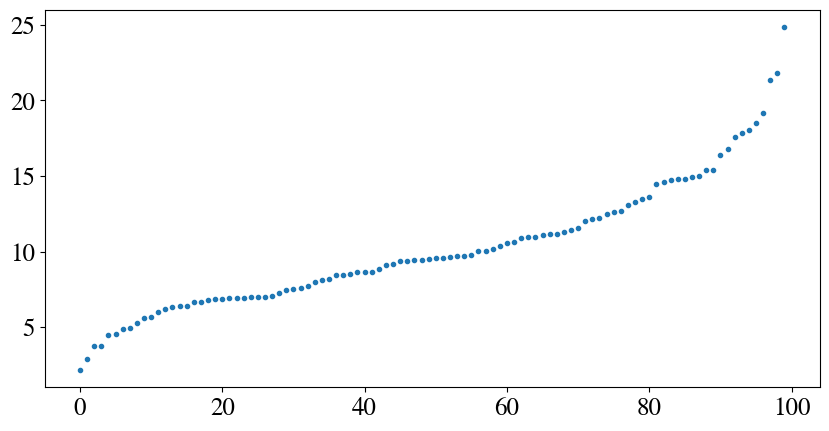

In [34]:
plt.plot(np.sort(T_vs), ".")